# Input/Output

In this section, we illustrate how to input and output **gridded** climate data with `cfr`.

`cfr` provides a useful class called `ClimateField` to handle **gridded** climate data.
It is essentially a wrapper of a `xarray.DataArray`, but with additional analysis and visualization functionalities added on.

Essentially, `cfr` supports below conversions:

- a netCDF file <=> `cfr.ClimateField`
- `xarray.DataArray` <=> `cfr.ClimateField`
- `numpy.ndarray` <=> `cfr.ClimateField`

In addition, `cfr` supports **remote loading** of hosted simulations.

Required data to complete this tutorial:

- GISTEMP surface temperature: [gistemp1200_GHCNv4_ERSSTv5.nc](https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz)
- HadCRUTv5 surface temperature: [HadCRUT.5.0.1.0.anomalies.ensemble_mean.nc](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/non-infilled/HadCRUT.5.0.1.0.anomalies.ensemble_mean.nc)

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import xarray as xr
import os
os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks/')

## a netCDF file => `cfr.ClimateField`

A simplest case is that the netCDF file contains only one variable with standard names for time, latitude, and longitude: `time`, `lat`, `lon`.
In this case, we just create a `cfr.ClimateField` object and call its `.load_nc()` method with a path to the netCDF file as the argument.

Sometimes, however, the netCDF file comes with multiple variables, in which case we need to specify the variable name via the `vn` argument:

In [2]:
dirpath = './data'
fd = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'gistemp1200_GHCNv4_ERSSTv5.nc'),  # path to the netCDF file
    vn='tempanomaly',  # specify the name of the variable to load
)
fd.da  # check the loaded `xarray.DataArray`

<xarray.DataArray 'tempanomaly' (time: 1718, lat: 90, lon: 180)>
[27831600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-02-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

If the netCDF file names the latitude and longitude dimensions with other differently, we will also need to speicify them.
For instance, below we are trying to load the HadCRUT dataset, which have different names for the coordinates:

In [3]:
ds = xr.open_dataset(os.path.join(dirpath, 'HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'))
ds

<xarray.Dataset>
Dimensions:           (time: 2076, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-1...
  * latitude          (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude         (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (latitude, bnds) float64 ...
    longitude_bnds    (longitude, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2023-01-10T22:32:59+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

We specify the `lon_name` and `lat_name` in the arguments so that the `.load_nc()` method can load the data correctly.
`time_name` may be also specified if its named differently in the netCDF file.
Once loaded, those coordinates will be renamed to the standard `time`, `lat`, and `lon`.

In [4]:
dirpath = './data'
fd = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'),
    time_name='time',       # specify the name of the time dimension
    lon_name='longitude',   # specify the name of the lontitude dimension
    lat_name='latitude',    # specify the name of the latitude dimension
    vn='tas_mean',          # specify the name of the variable to load
)
fd.da  # check the loaded `xarray.DataArray`

<xarray.DataArray 'tas_mean' (time: 2076, lat: 36, lon: 72)>
[5380992 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## `cfr.ClimateField` => a netCDF file

A `cfr.ClimateField` can be output to a netCDF file easily with the `.to_nc()` method:

In [5]:
fd.to_nc('./data/fd.nc')

ClimateField.da["tas_mean"] saved to: ./data/fd.nc


Now let's check if the saved netCDF file looks fine:

In [6]:
da = xr.open_dataarray('./data/fd.nc')
da

<xarray.DataArray 'tas_mean' (time: 2076, lat: 36, lon: 72)>
[5380992 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## `xarray.DataArray` => `cfr.ClimateField`

Sometimes, we will load a `xarray.DataArray` first, after which we may convert it to a `cfr.ClimateField` with the `.from_da()` method:

In [7]:
fd = cfr.ClimateField(da)
fd.da

<xarray.DataArray 'tas_mean' (time: 2076, lat: 36, lon: 72)>
[5380992 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## `cfr.ClimateField` => `xarray.DataArray`

The convertion from a `cfr.ClimateField` to a `xarray.DataArray` is trivial: simply access the `.da` attribute:

In [8]:
da = fd.da
da

<xarray.DataArray 'tas_mean' (time: 2076, lat: 36, lon: 72)>
[5380992 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

## `numpy.ndarray` => `cfr.ClimateField`

We may also convert a collection of `numpy.ndarray`s to a `cfr.ClimateField`:

In [9]:
time = da.time.values
lat = da.lat.values
lon = da.lon.values
value = da.values
print(type(time), type(lat), type(lon), type(value))
print(value.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2076, 36, 72)


In [10]:
fd = cfr.ClimateField().from_np(
    time, lat, lon, value,
)
fd.da

<xarray.DataArray (time: 2076, lat: 36, lon: 72)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-0.7109375, -0.7421875, -0.8046875, ..., -0.6875   ,
         -0.6875   , -0.6875   ],
        [-0.890625 , -0.921875 , -0.9609375, ...,        nan,
                nan, -0.875    ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [ 2.6875   ,  2.1328125,  2.984375 , ...,  4.75     ,
          4.796875 ,  4.0859375],
        [ 4.4296875,  4.53125  ,  4.5      , ...,  4.0078125,
          4.171875 ,  4.3125   ],
        [ 3.6015625,  3.640625 ,  3.671875 , ...,  3.484375 ,
          3.5234375,  3.5703125]],

       [[-1.0859375, -1.109375 , -1.125    , ..., -1.0234375,
         -1.046875 , -1.0703125],
        [-1.0546875, -1.0859375, -1.1171875, ..., -0.953125 ,
         -0.984375 , -1.0234375],
        [-0.8359375, -0.8828125, -0.9453125, ..., -0.7265625,
         -0.7578125, -0.796875 ],
        ...,
        [ 1.3203125,  1.2578125,  2.09375  , ...,  1.90625  ,
          1.875    ,  1.6484375],
        [ 3.6953125,  3.7890625,  3.578125 , ...,  3.5390625,
          3.5703125,  3.625    ],
        [ 4.4921875,  4.515625 ,  4.5390625, ...,  4.421875 ,
          4.4453125,  4.46875  ]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5

## `cfr.ClimateField` => `numpy.ndarray`

The conversion from a `cfr.ClimateField` to a collection of `numpy.ndarray`s is trivial:

In [11]:
time = fd.da.time.values
lat = fd.da.lat.values
lon = fd.da.lon.values
value = fd.da.values
print(type(time), type(lat), type(lon), type(value))
print(value.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2076, 36, 72)


## Remote loading simulations

`cfr` supports remote loading of hosted simulations in netCDF files, currently including iCESM past1000 and past1000historical.

By calling the `.fetch()` method of `ClimateField` without any arguments, a list of supported simulation names will be listed:

In [4]:
fd = cfr.ClimateField().fetch()

>>> Choose one from the supported entries: ['iCESM_past1000historical/tas', 'iCESM_past1000historical/pr']


### Remote loading iCESM simulations

The target netCDF file will be downloaded to the relative directory `./data` if not existed (skipped if existed), after which a `ClimateField()` will be built with that netCDF file.

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


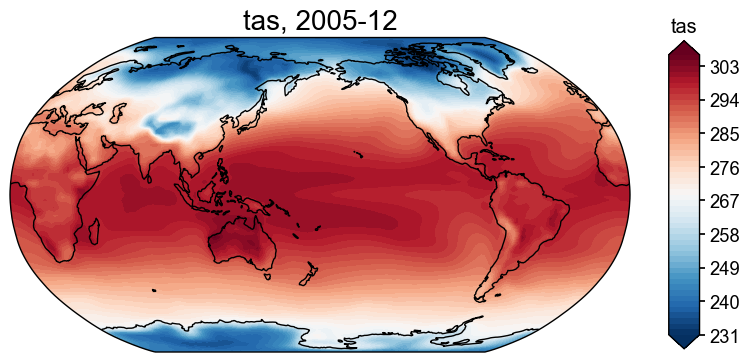

In [6]:
# the case when the file exists already
fd = cfr.ClimateField().fetch('iCESM_past1000historical/tas')
fig, ax = fd[-1].plot()

Fetching data: 100%|██████████| 633M/633M [00:09<00:00, 66.7MiB/s] 


>>> Downloaded file saved at: ./data/tas_sfc_Amon_iCESM_past1000_085001-184912.nc .


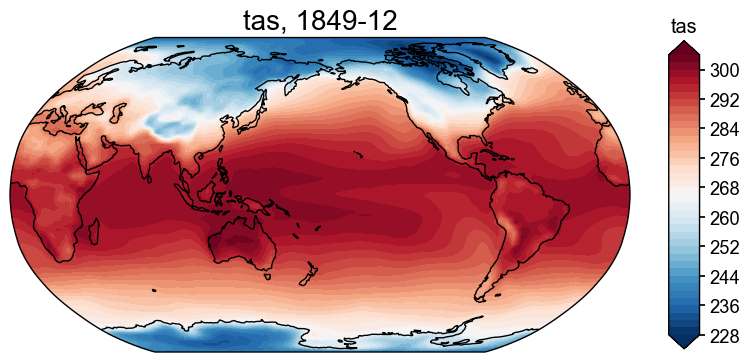

In [10]:
# the case when the file doesn't exist
fd = cfr.ClimateField().fetch('iCESM_past1000/tas')
fig, ax = fd[-1].plot()

We may also specify a URL to fetch arbitray netCDF files:

Fetching data: 100%|██████████| 633M/633M [00:10<00:00, 66.2MiB/s] 


>>> Downloaded file saved at: ./data/pr_sfc_Amon_iCESM_past1000_085001-184912.nc .


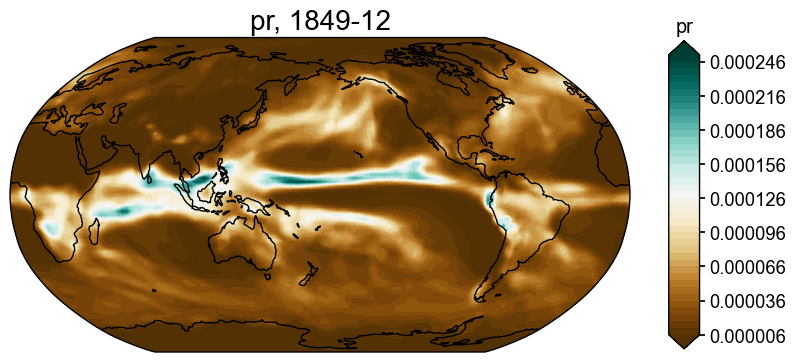

In [12]:
fd = cfr.ClimateField().fetch('https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000_085001-184912.nc')
fig, ax = fd[-1].plot()